# Imports #

In [1]:
import yfinance as yf
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Getting the data #

In [2]:
#Stock data is the historical stock data until one month ago
stock_data = yf.download('AAPL', start='2020-01-01', end=datetime.date.today() - datetime.timedelta(days=30))
# test_data is the stock data for the previous month
test_data = yf.download('AAPL', start = datetime.date.today() - datetime.timedelta(days=29), end = datetime.date.today())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449409,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735321,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314896,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970085,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143890,132079200


In [4]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-17,134.830002,137.289993,134.130005,135.940002,135.732758,63646600
2023-01-18,136.820007,138.610001,135.029999,135.210007,135.003876,69672800
2023-01-19,134.080002,136.250000,133.770004,135.270004,135.063782,58280400
2023-01-20,135.279999,138.020004,134.220001,137.869995,137.659805,79972200
2023-01-23,138.119995,143.320007,137.899994,141.110001,140.894882,81760300


Text(0, 0.5, 'Closing Price')

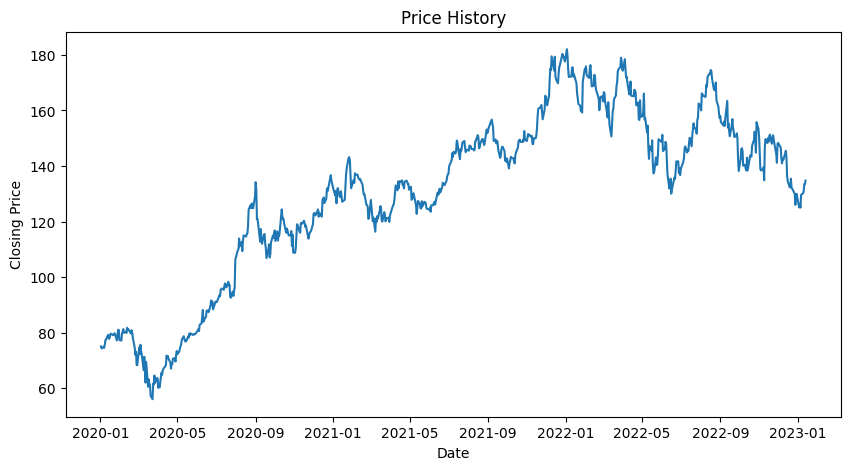

In [5]:
#Visualizing the data
plt.figure(figsize=(10, 5))
plt.title('Price History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

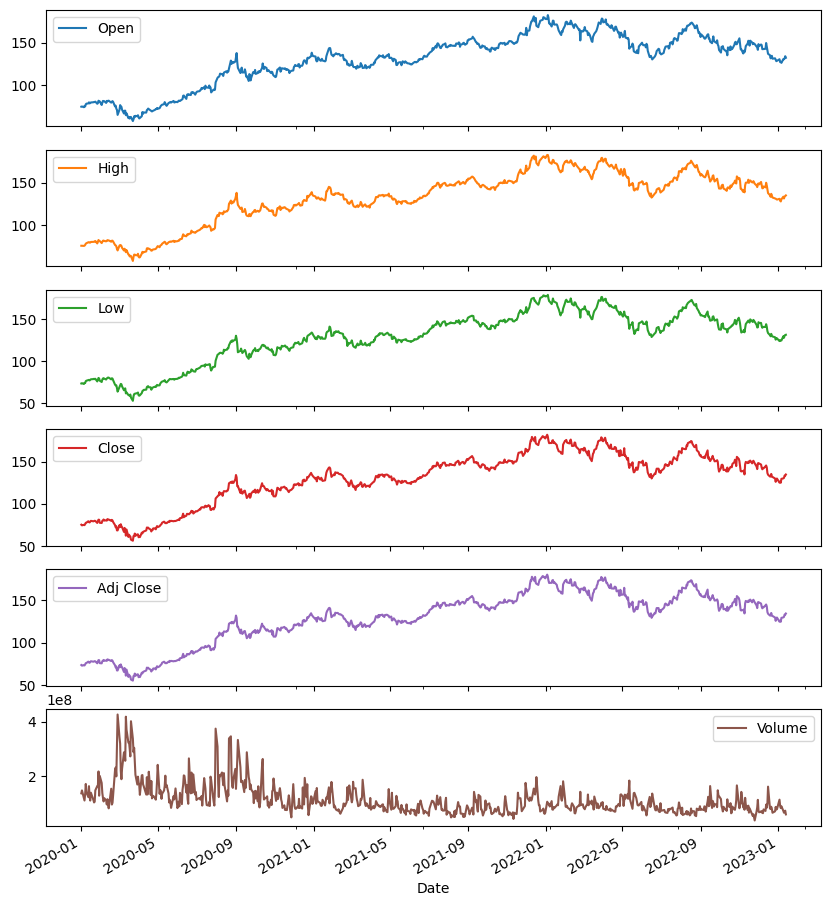

In [6]:
stock_data.plot(subplots=True, figsize=(10, 12))

# Data Preprocessing #

In [7]:
#Scaling the data
sc = MinMaxScaler(feature_range=(-1, 1))
stock_data['Close'] = sc.fit_transform(stock_data['Close'].values.reshape(-1, 1))
stock_data['Close']

Date
2020-01-02   -0.698294
2020-01-03   -0.709889
2020-01-06   -0.700479
2020-01-07   -0.706077
2020-01-08   -0.687017
                ...   
2023-01-09    0.176286
2023-01-10    0.185498
2023-01-11    0.229337
2023-01-12    0.228066
2023-01-13    0.249509
Name: Close, Length: 765, dtype: float64

In [8]:
close_data = stock_data[['Close']]

In [9]:
# convert to numpy array
data_raw = close_data.to_numpy()
data = []
    
# create all possible sequences of length seq_len
for index in range(len(data_raw) - 60): 
    data.append(data_raw[index: index + 60])
    
data = np.array(data)
test_set_size = int(np.round(0.2*data.shape[0]))
train_set_size = data.shape[0] - (test_set_size)
    
x_train = data[:train_set_size,:-1,:]
y_train = data[:train_set_size,-1,:]
    
x_test = data[train_set_size:,:-1]
y_test = data[train_set_size:,-1,:]
     

In [10]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (564, 59, 1)
y_train.shape =  (564, 1)
x_test.shape =  (141, 59, 1)
y_test.shape =  (141, 1)


# Model Creation #

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
564/564 [==============================] - 8s 12ms/step - loss: 0.0125
Epoch 2/3
564/564 [==============================] - 7s 12ms/step - loss: 0.0057
Epoch 3/3
564/564 [==============================] - 7s 12ms/step - loss: 0.0042


In [13]:
predict = model.predict(x_test)
predict = sc.inverse_transform(predict)
rmse = np.sqrt(np.mean(predict - y_test)**2)
rmse

5/5 [==============================] - 1s 11ms/step


148.73532654277753

In [14]:
original = sc.inverse_transform(y_test)
print(original)

[[138.27000427]
 [141.66000366]
 [141.66000366]
 [137.44000244]
 [139.22999573]
 [136.72000122]
 [138.92999268]
 [141.55999756]
 [142.91999817]
 [146.3500061 ]
 [147.03999329]
 [144.86999512]
 [145.86000061]
 [145.49000549]
 [148.47000122]
 [150.16999817]
 [147.07000732]
 [151.        ]
 [153.03999329]
 [155.3500061 ]
 [154.08999634]
 [152.94999695]
 [151.6000061 ]
 [156.78999329]
 [157.3500061 ]
 [162.50999451]
 [161.50999451]
 [160.00999451]
 [166.13000488]
 [165.80999756]
 [165.3500061 ]
 [164.86999512]
 [164.91999817]
 [169.24000549]
 [168.49000549]
 [172.1000061 ]
 [173.19000244]
 [173.02999878]
 [174.55000305]
 [174.1499939 ]
 [171.52000427]
 [167.57000732]
 [167.22999573]
 [167.52999878]
 [170.02999878]
 [163.61999512]
 [161.38000488]
 [158.91000366]
 [157.22000122]
 [157.96000671]
 [155.80999756]
 [154.52999878]
 [155.96000671]
 [154.46000671]
 [157.36999512]
 [163.42999268]
 [153.83999634]
 [155.30999756]
 [152.36999512]
 [150.69999695]
 [154.47999573]
 [156.8999939 ]
 [153.72

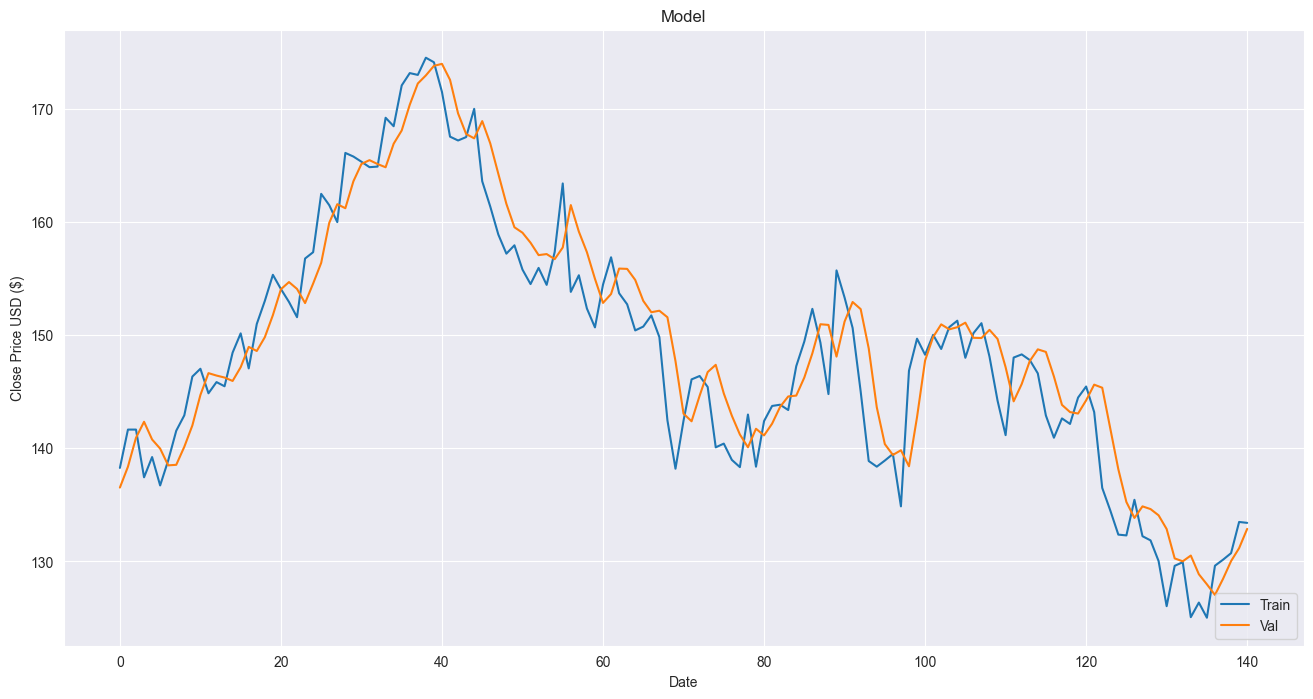

In [20]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(original)
plt.plot(predict)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, ''),
 Text(140.0, 0, ''),
 Text(160.0, 0, '')]

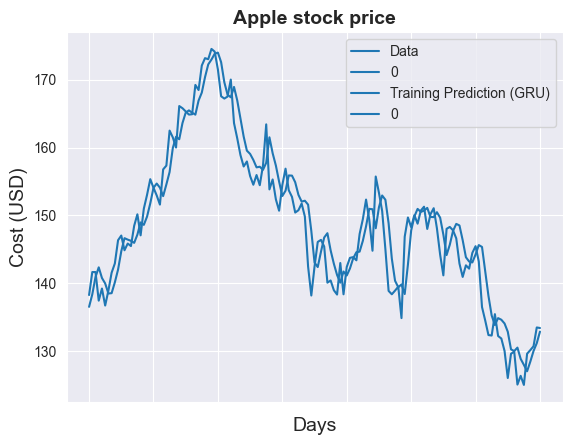

In [23]:
import seaborn as sns
sns.set_style("darkgrid")    

ax = sns.lineplot(data=original, label="Data", color='royalblue')
ax = sns.lineplot(data=predict, label="Training Prediction (GRU)", color='tomato')
ax.set_title('Apple stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)